In [ ]:
!pip install node2vec

In [ ]:
pip uninstall gensim

In [ ]:
!pip install gensim==3.8.3

In [ ]:
import gensim
print(gensim.__version__)

3.8.3


In [ ]:
import os
import sys
import numpy as np 
import pandas as pd
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split


In [ ]:
links = pd.read_csv('train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [ ]:
path = '/content/node_information.csv'
nodes_info_df = pd.read_csv(path, header=None)

col_names = []
for i in range(1, len(nodes_info_df.columns)):
  col_names.append(f'info_{i}')

col_names = ['node'] + col_names
nodes_info_df.columns = col_names

In [ ]:
def CreateGraph (X, y, directed = False):
    
    if directed:
        G = nx.from_pandas_edgelist(X, 'node', 'target', create_using=nx.DiGraph())
    else:    
        G = nx.from_pandas_edgelist(X[y == 1], 'node', 'target', create_using=nx.Graph())
        
    G.add_nodes_from(range(10496))
    
    return G

In [ ]:
G = CreateGraph(X, y)

In [ ]:
import networkx as nx
from node2vec import Node2Vec
import numpy as np

# Generate random walks using node2vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=100, workers=4)
model = node2vec.fit()
walks = model.walks

# Generate node embeddings
embeddings = {}
for node in G.nodes():
    embeddings[node] = model.wv[node]

# Prepare features for link prediction
features = []
for edge in G.edges():
    node1 = edge[0]
    node2 = edge[1]
    feature = np.concatenate([embeddings[node1], embeddings[node2]])
    features.append(feature)

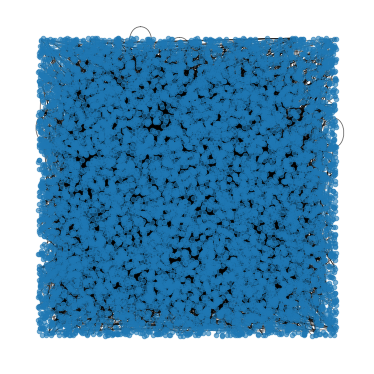

In [ ]:
# Plot graph
plt.figure(figsize=(5,5))

pos = nx.random_layout(G, seed=19)
nx.draw(G, with_labels=False,  pos = pos, node_size = 20, alpha = 0.6, width = 0.8)

plt.show()

In [ ]:
def sorensen_index(G, tuple_list):
  res = []
  for el in tuple_list:
    n_x = set(G.neighbors(el[0]))
    n_y = set(G.neighbors(el[1]))
    res.append((el[0], el[1], round(len(n_x.intersection(n_y)) / (len(n_x) + len(n_y)), 8))) 

  return res

def  hub_promoted_index(G, tuple_list):
  res = []
  for el in tuple_list:
    n_x = set(G.neighbors(el[0]))
    n_y = set(G.neighbors(el[1]))
    min_n = min(len(n_x), len(n_y))
    r = round(len(n_x.intersection(n_y)) / min_n, 8)

    res.append((el[0], el[1], r)) 

  return res

def  hub_depressed_index(G, tuple_list):
  res = []
  for el in tuple_list:
    n_x = set(G.neighbors(el[0]))
    n_y = set(G.neighbors(el[1]))
    max_n = max(len(n_x), len(n_y))
    r = round(len(n_x.intersection(n_y)) / max_n, 8)

    res.append((el[0], el[1], r)) 

  return res

def  local_affinity_structure_index(G, tuple_list):
  res = []
  for el in tuple_list:
    n_x = set(G.neighbors(el[0]))
    n_y = set(G.neighbors(el[1]))
    inter = len(n_x.intersection(n_y))

    r = round(inter/len(n_x) + inter/len(n_y), 8) 

    res.append((el[0], el[1], r)) 

  return res

def  car_based_index(G, tuple_list):
  res = []
  for el in tuple_list:
    n_x = set(G.neighbors(el[0]))
    n_y = set(G.neighbors(el[1]))
    inter = n_x.intersection(n_y)

    r = round(len(inter) * sum([len(list(G.neighbors(el)))/2 for el in inter]), 8)

    res.append((el[0], el[1], r)) 

  return res

def common_neighbors(G, tuple_list):
  res = [
      (el[0], el[1], len(list(nx.common_neighbors(G, el[0], el[1]))))
      for el in tuple_list
  ]

  return res

In [ ]:
def AppendNextworkxFeature (function, G, X):
    
    column_name = str(function).split()[1]
    
    tuple_list = list(X[['node','target']].itertuples(index=False, name=None))
    coef_generator = function(G, tuple_list)
    coef_df = pd.DataFrame(coef_generator)
    X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [ ]:
def nxGenerateFeatures (X_train, X_test, y_train):
    
    G = CreateGraph (X_train, y_train)
    
    linkPredictionFunctions = [nx.resource_allocation_index, nx.jaccard_coefficient, nx.preferential_attachment, car_based_index, common_neighbors]#, nx.adamic_adar_index]
    for function in linkPredictionFunctions:
        AppendNextworkxFeature(function, G, X_train)
        AppendNextworkxFeature(function, G, X_test)
        
    return X_train, X_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
X_train, X_test = nxGenerateFeatures(X_train, X_test, y_train)

In [ ]:
X_test

,node,target,preferential_attachment,jaccard_coefficient,resource_allocation_index
5118,3839,7571,0,0.0,0.0
7395,132,3809,598,0.0,0.0
8513,4551,7127,4,0.0,0.0
10313,225,6743,0,0.0,0.0
7621,887,3849,147,0.0,0.0
...,...,...,...,...,...
2753,61,2276,1,0.0,0.0
1446,803,3809,0,0.0,0.0
4989,270,6761,56,0.0,0.0
1020,132,435,2,0.0,0.0


In [ ]:
import networkx as nx

In [ ]:
links = pd.read_csv('test.txt', header = None, 
                    sep = ' ', names = ['node', 'target'])
X_submission = links[['node', 'target']]

In [ ]:
X, X_submission = nxGenerateFeatures (X, X_submission, y)
#X, X_test, y = nxGenerateFeatures(X, X_test, y)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost classifier with default parameters
xgb_model = xgb.XGBClassifier()

# Define the range of hyperparameters to search over
params = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Define randomized search cross-validation with 5-fold
rand_search = RandomizedSearchCV(
    xgb_model, params, n_iter=100, cv=5, scoring='accuracy', random_state=42
)

# Fit the model
rand_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", rand_search.best_params_)
print("Best Accuracy: ", rand_search.best_score_)

# Create XGBoost classifier with tuned hyperparameters
xgb_model_tuned = xgb.XGBClassifier(
    n_estimators=rand_search.best_params_['n_estimators'],
    max_depth=rand_search.best_params_['max_depth'],
    learning_rate=rand_search.best_params_['learning_rate'],
    subsample=rand_search.best_params_['subsample'],
    colsample_bytree=rand_search.best_params_['colsample_bytree'],
    gamma=rand_search.best_params_['gamma'],
    reg_alpha=rand_search.best_params_['reg_alpha'],
    reg_lambda=rand_search.best_params_['reg_lambda'],
    random_state=42
)

# Perform cross-validation with the tuned model
scores = cross_val_score(xgb_model_tuned, X_train, y_train, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean Accuracy: ", scores.mean())
print("Standard Deviation: ", scores.std())

# Fit the tuned model to the training data
xgb_model_tuned.fit(X_train, y_train)

# Predict the test data
y_pred = xgb_model_tuned.predict(X_test)

# Evaluate the model on the test data
print("Accuracy on Test Data: ", accuracy_score(y_test, y_pred))


Best Hyperparameters:  {'colsample_bytree': 0.6504391549083848, 'gamma': 0.2848404943774676, 'learning_rate': 0.0284434736772664, 'max_depth': 3, 'n_estimators': 101, 'reg_alpha': 0.5026790232288615, 'reg_lambda': 0.05147875124998935, 'subsample': 0.6393232321183058}
Best Accuracy:  0.7597793018552712
Cross-validation scores:  [0.76694678 0.75672646 0.75392377 0.76065022 0.75896861]
Mean Accuracy:  0.7594431674014899
Standard Deviation:  0.0043779143380541525
Accuracy on Test Data:  0.6317460317460317


In [ ]:
X

In [ ]:
#No validation
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define XGBoost classifier with default parameters
xgb_model = xgb.XGBClassifier()

# Define the range of hyperparameters to search over
params = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Define randomized search cross-validation with 5-fold
rand_search = RandomizedSearchCV(
    xgb_model, params, n_iter=100, cv=5, scoring='accuracy', random_state=42
)

# Fit the model
rand_search.fit(X, y)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", rand_search.best_params_)
print("Best Accuracy: ", rand_search.best_score_)

# Create XGBoost classifier with tuned hyperparameters
xgb_model_tuned = xgb.XGBClassifier(
    n_estimators=rand_search.best_params_['n_estimators'],
    max_depth=rand_search.best_params_['max_depth'],
    learning_rate=rand_search.best_params_['learning_rate'],
    subsample=rand_search.best_params_['subsample'],
    colsample_bytree=rand_search.best_params_['colsample_bytree'],
    gamma=rand_search.best_params_['gamma'],
    reg_alpha=rand_search.best_params_['reg_alpha'],
    reg_lambda=rand_search.best_params_['reg_lambda'],
    random_state=42
)

# Fit the tuned model
xgb_model_tuned.fit(X, y)

Best Hyperparameters:  {'colsample_bytree': 0.9145821103532572, 'gamma': 0.5690814691657476, 'learning_rate': 0.041755914795000675, 'max_depth': 3, 'n_estimators': 198, 'reg_alpha': 0.1338521188006332, 'reg_lambda': 0.013671964826997285, 'subsample': 0.5376795301762312}
Best Accuracy:  0.7530479366591801


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9145821103532572, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5690814691657476, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.041755914795000675, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=198, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
y_pred_train = xgb_model_tuned.predict(X)
y_pred = xgb_model_tuned.predict(X_submission)

print('performance over the training set: ' + str(f1_score(y, y_pred_train)))
#print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
#print(classification_report(y, y_pred))

performance over the training set: 0.7518974864465254


In [ ]:
xgb_model = XGBClassifier(learning_rate=0.02, 
                                        n_estimators=1000,
                                        max_depth=3,
                                        min_child_weight=1,                         
                                        gamma=0.28,
                                        colsample_bytree=0.65,
                                        subsample=0.64,
                                        objective ='binary:logistic',                   
                                        reg_lambda=0.05,
                                        reg_alpha=0.5,
                                        scale_pos_weight = 1,
                                        tree_method='gpu_hist',
                                        seed=42)


xgb_model.fit(X,y)
y_pred_train = xgb_model.predict(X)
y_pred = xgb_model.predict(X_submission)


print('performance over the training set: ' + str(f1_score(y, y_pred_train)))
#print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
#print(classification_report(y, y_pred))

performance over the training set: 0.7588652482269503


In [ ]:
# pd.DataFrame(y_pred, columns = ['predicted']).to_csv(result_file_name, sep=',', index=True, index_label='id')

In [ ]:
!pip install catboost

In [ ]:
import catboost as cb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost classifier with default parameters
cb_model = cb.CatBoostClassifier()

# Define the range of hyperparameters to search over
params = {
    'iterations': randint(100, 1000),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bylevel': uniform(0.5, 0.5),
    'l2_leaf_reg': uniform(0, 1),
}

# Define randomized search cross-validation with 5-fold
rand_search = RandomizedSearchCV(
    cb_model, params, n_iter=100, cv=5, scoring='accuracy', random_state=42
)

# Fit the model
rand_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", rand_search.best_params_)
print("Best Accuracy: ", rand_search.best_score_)

# Create XGBoost classifier with tuned hyperparameters
cb_model_tuned = cb.CatBoostClassifier(
    iterations=rand_search.best_params_['iterations'],
    depth=rand_search.best_params_['depth'],
    learning_rate=rand_search.best_params_['learning_rate'],
    subsample=rand_search.best_params_['subsample'],
    colsample_bylevel=rand_search.best_params_['colsample_bylevel'],
    l2_leaf_reg=rand_search.best_params_['l2_leaf_reg'],
    random_state=42
)

# Perform cross-validation with the tuned model
scores = cross_val_score(cb_model_tuned, X_train, y_train, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean Accuracy: ", scores.mean())
print("Standard Deviation: ", scores.std())

# Fit the tuned model to the training data
cb_model_tuned.fit(X_train, y_train)

# Predict the test data
y_pred = cb_model_tuned.predict(X_test)

# Evaluate the model on the test data
print("Accuracy on Test Data: ", accuracy_score(y_test, y_pred))


In [ ]:
cb_model = cb.CatBoostClassifier(learning_rate=0.038, 
                                        iterations=111,
                                        depth=9,
                                        colsample_bylevel=0.79,
                                        subsample=0.69,                  
                                        l2_leaf_reg=0.96,
                                        random_state=42)


cb_model.fit(X,y)
y_pred_train = cb_model.predict(X)
print('performance over the training set: ' + str(f1_score(y, y_pred_train)))

y_pred = cb_model.predict(X_submission)

In [ ]:
#no validation
# import catboost as cb
# from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
# from scipy.stats import randint, uniform
# from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost classifier with default parameters
cb_model = cb.CatBoostClassifier()

# Define the range of hyperparameters to search over
params = {
    'iterations': randint(100, 1000),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bylevel': uniform(0.5, 0.5),
    'l2_leaf_reg': uniform(0, 1),
}

# Define randomized search cross-validation with 5-fold
rand_search = RandomizedSearchCV(
    cb_model, params, n_iter=100, cv=5, scoring='accuracy', random_state=42
)

# Fit the model
rand_search.fit(X, y)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", rand_search.best_params_)
print("Best Accuracy: ", rand_search.best_score_)

# Create XGBoost classifier with tuned hyperparameters
cb_model_tuned = cb.CatBoostClassifier(
    iterations=rand_search.best_params_['iterations'],
    depth=rand_search.best_params_['depth'],
    learning_rate=rand_search.best_params_['learning_rate'],
    subsample=rand_search.best_params_['subsample'],
    colsample_bylevel=rand_search.best_params_['colsample_bylevel'],
    l2_leaf_reg=rand_search.best_params_['l2_leaf_reg'],
    random_state=42
)

# Fit the tuned model
cb_model_tuned.fit(X, y)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Random Forest classifier with default parameters
rf_model = RandomForestClassifier()

# Define the range of hyperparameters to search over
params = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'max_features': uniform(0.1, 0.9),
    'min_samples_split': uniform(0, 1),
    'min_samples_leaf': uniform(0, 0.5),
}

# Define randomized search cross-validation with 5-fold
rand_search = RandomizedSearchCV(
    rf_model, params, n_iter=100, cv=5, scoring='accuracy', random_state=42
)

# Fit the model
rand_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", rand_search.best_params_)
print("Best Accuracy: ", rand_search.best_score_)

# Create Random Forest classifier with tuned hyperparameters
rf_model_tuned = RandomForestClassifier(
    n_estimators=rand_search.best_params_['n_estimators'],
    max_depth=rand_search.best_params_['max_depth'],
    max_features=rand_search.best_params_['max_features'],
    min_samples_split=rand_search.best_params_['min_samples_split'],
    min_samples_leaf=rand_search.best_params_['min_samples_leaf'],
    random_state=42
)

# Perform cross-validation with the tuned model
scores = cross_val_score(rf_model_tuned, X_train, y_train, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean Accuracy: ", scores.mean())
print("Standard Deviation: ", scores.std())

# Fit the tuned model to the training data
rf_model_tuned.fit(X_train, y_train)

# Predict the test data
y_pred = rf_model_tuned.predict(X_test)

# Evaluate the model on the test data
print("Accuracy on Test Data: ", accuracy_score(y_test, y_pred))


Best Hyperparameters:  {'max_depth': 4, 'max_features': 0.1845837458567821, 'min_samples_leaf': 0.289140070498087, 'min_samples_split': 0.035942273796742086, 'n_estimators': 764}
Best Accuracy:  0.7586582884274786
Cross-validation scores:  [0.76638655 0.75672646 0.74831839 0.76065022 0.75840807]
Mean Accuracy:  0.7580979387270604
Standard Deviation:  0.005879321671270558
Accuracy on Test Data:  0.6279365079365079


In [ ]:
y_pred = rf_model_tuned.predict(X_submission)

In [ ]:
df_out = pd.DataFrame(y_pred, columns = ['Predicted'])

In [ ]:
y_pred = cb_model_tuned.predict(X_submission) 
df_out = pd.DataFrame(y_pred, columns = ['Predicted'])
df_out = df_out.reset_index()
df_out = df_out.rename(columns={'index': 'ID'})
df_out.to_csv('final_results_cb_tune4.csv', index=False)

In [ ]:
df_out

,ID,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
3493,3493,1
3494,3494,0
3495,3495,1
3496,3496,0


In [ ]:
df_out.to_csv('final_results_rf_tune1.csv', index=False)

In [ ]:
# Count the unique values in the "node" column of X_test
node_counts = X_test['node'].value_counts()

In [ ]:
filtered_df = df_out[df_out['ID'] == 0]

In [ ]:
filtered_df

,ID,Predicted
0,0,0


In [ ]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         3498 non-null   int64
 1   Predicted  3498 non-null   int64
dtypes: int64(2)
memory usage: 54.8 KB
